# <b><div style='padding:15px;background-color:#850E35;color:white;border-radius:2px;font-size:110%;text-align: center'> Multiclass Classification using CNN with TensorFlow </div></b>

![](https://img.freepik.com/free-vector/kids-playing-rock-scissors-paper_1308-5838.jpg?w=900&t=st=1686054162~exp=1686054762~hmac=bb8f147b3ab5fa88cba60e4553cddc1488186d08112e57689405caaef31a705d)

Hi guys ðŸ˜€ This notebook walks you through how to classify rock-paper-scissors images with TensorFlow.

Table of contents:
<ul>
<li><a href="#importing">Importing required libraries </a></li>  
<li><a href="#understanding">Understanding the dataset</a></li>         
<li><a href="#preprocessing">Data preprocessing</a></li>
<li><a href="#configure">Configure the dataset for performance</a></li>
<li><a href="#augmentation">Data augmentation</a></li>
<li><a href="#building">Building the model </a></li>
<li><a href="#visualizing">Visualizing training results</a></li>
<li><a href="#predicting">Predicting on new data</a></li>   
<li><a href="#wrapup">Wrap up</a></li>   
</ul>

Let's get started ðŸš€

<a id='importing'></a>
# <b><div style='padding:15px;background-color:#850E35;color:white;border-radius:2px;font-size:110%;text-align: center'>Importing Required Libraries </div></b>

In [1]:
import os 
import random
import numpy as np
import matplotlib.pyplot as plt

<a id='understanding'></a>
# <b><div style='padding:15px;background-color:#850E35;color:white;border-radius:2px;font-size:110%;text-align: center'>Understanding the Dataset</div></b>

In [2]:
base_dir = '/kaggle/input/rockpaperscissors/rps-cv-images'
paper_dir = os.path.join(base_dir,'paper')
rock_dir = os.path.join(base_dir,'rock')
scissors_dir = os.path.join(base_dir,'scissors')

In [3]:
print("Rock : ",len(os.listdir(rock_dir)))
print("Paper : ",len(os.listdir(paper_dir)))
print("Scissors : ",len(os.listdir(scissors_dir)))

Rock :  726
Paper :  712
Scissors :  750


/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

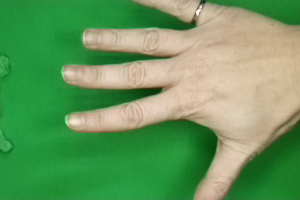

In [4]:
import tensorflow as tf
random_image = random.sample(os.listdir(paper_dir), 1)
img = tf.keras.utils.load_img(f"{paper_dir}/{random_image[0]}")
img

In [5]:
img = tf.keras.utils.img_to_array(img)
img.shape

(200, 300, 3)

<a id='preprocessing'></a>
# <b><div style='padding:15px;background-color:#850E35;color:white;border-radius:2px;font-size:110%;text-align: center'>Data Preprocessing</div></b>

In [6]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  base_dir,
  validation_split=0.2,
  subset="training",
  image_size=(180,180),
  batch_size=32,
  seed=42)

Found 2188 files belonging to 3 classes.
Using 1751 files for training.


In [7]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  base_dir,
  validation_split=0.2,
  subset="validation",
  image_size=(180,180),
  batch_size=32,
  seed=42)

Found 2188 files belonging to 3 classes.
Using 437 files for validation.


In [8]:
class_names = train_ds.class_names
class_names

['paper', 'rock', 'scissors']

In [9]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


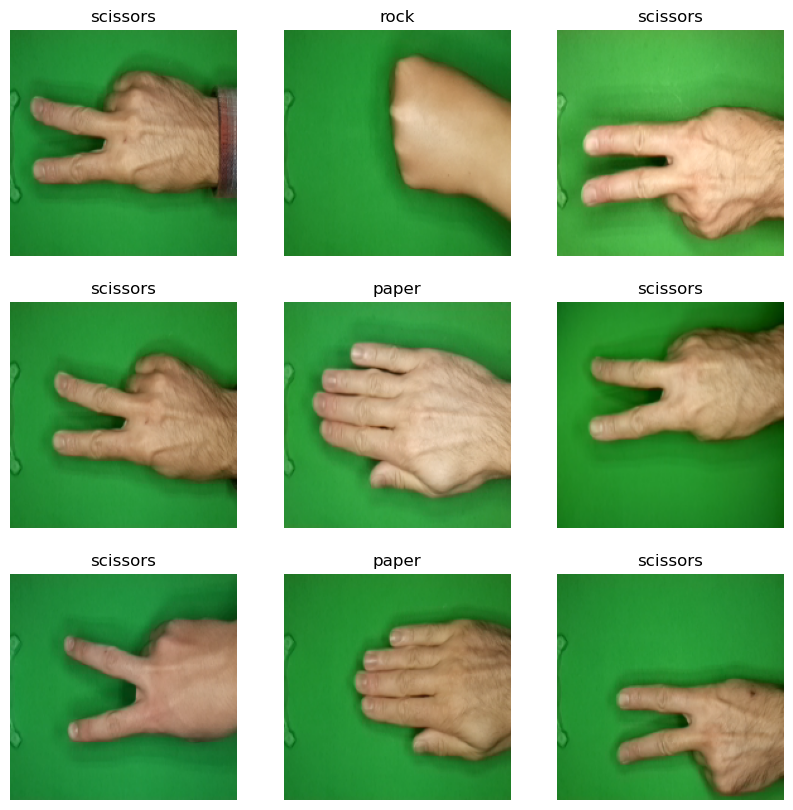

In [10]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

<a id='configure'></a>
# <b><div style='padding:15px;background-color:#850E35;color:white;border-radius:2px;font-size:110%;text-align: center'>Configuring the Dataset for Performance</div></b>

In [11]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

<a id='augmentation'></a>
# <b><div style='padding:15px;background-color:#850E35;color:white;border-radius:2px;font-size:110%;text-align: center'>Data Augmentation </div></b>

In [12]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical", seed=42),
  tf.keras.layers.RandomRotation(0.1, seed=42),
])

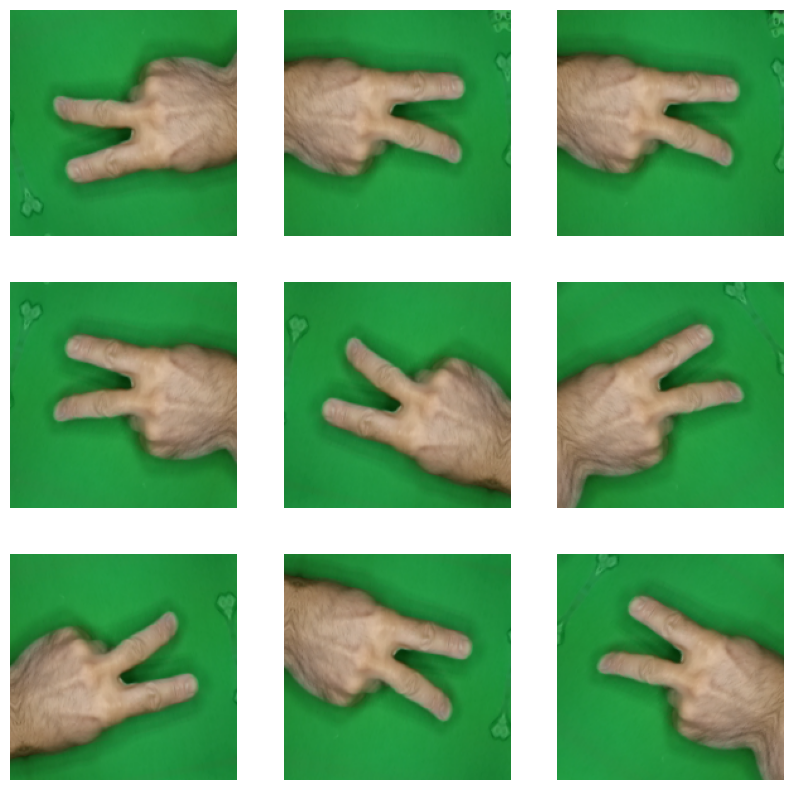

In [13]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

<a id='building'></a>
# <b><div style='padding:15px;background-color:#850E35;color:white;border-radius:2px;font-size:110%;text-align: center'>Building the Model</div></b>

In [14]:
NUM_CLASSES = len(class_names)
model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255, input_shape=(180, 180, 3)),
    data_augmentation,
    # The first CNN layer
    tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    # The second CNN layer
    tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    # The third CNN layer
    tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    # The fourth CNN layer
    tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES)
])

In [15]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 128)     3584      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 128)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 128)       147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 128)      0         
 2D)                                                  

In [16]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [17]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=15,
)

Epoch 1/15
55/55 [==============================] - 16s 109ms/step - loss: 1.1520 - accuracy: 0.3935 - val_loss: 0.9110 - val_accuracy: 0.5240
Epoch 2/15
55/55 [==============================] - 3s 50ms/step - loss: 0.5758 - accuracy: 0.7584 - val_loss: 0.1907 - val_accuracy: 0.9314
Epoch 3/15
55/55 [==============================] - 3s 50ms/step - loss: 0.3347 - accuracy: 0.8784 - val_loss: 0.1684 - val_accuracy: 0.9428
Epoch 4/15
55/55 [==============================] - 3s 50ms/step - loss: 0.2771 - accuracy: 0.8961 - val_loss: 0.2285 - val_accuracy: 0.9336
Epoch 5/15
55/55 [==============================] - 3s 50ms/step - loss: 0.2430 - accuracy: 0.9086 - val_loss: 0.1100 - val_accuracy: 0.9565
Epoch 6/15
55/55 [==============================] - 3s 50ms/step - loss: 0.1913 - accuracy: 0.9315 - val_loss: 0.1554 - val_accuracy: 0.9428
Epoch 7/15
55/55 [==============================] - 3s 50ms/step - loss: 0.1799 - accuracy: 0.9338 - val_loss: 0.1114 - val_accuracy: 0.9680
Epoch 8/15


<a id='visualizing'></a>
# <b><div style='padding:15px;background-color:#850E35;color:white;border-radius:2px;font-size:110%;text-align: center'>Visualizing Training Results</div></b>

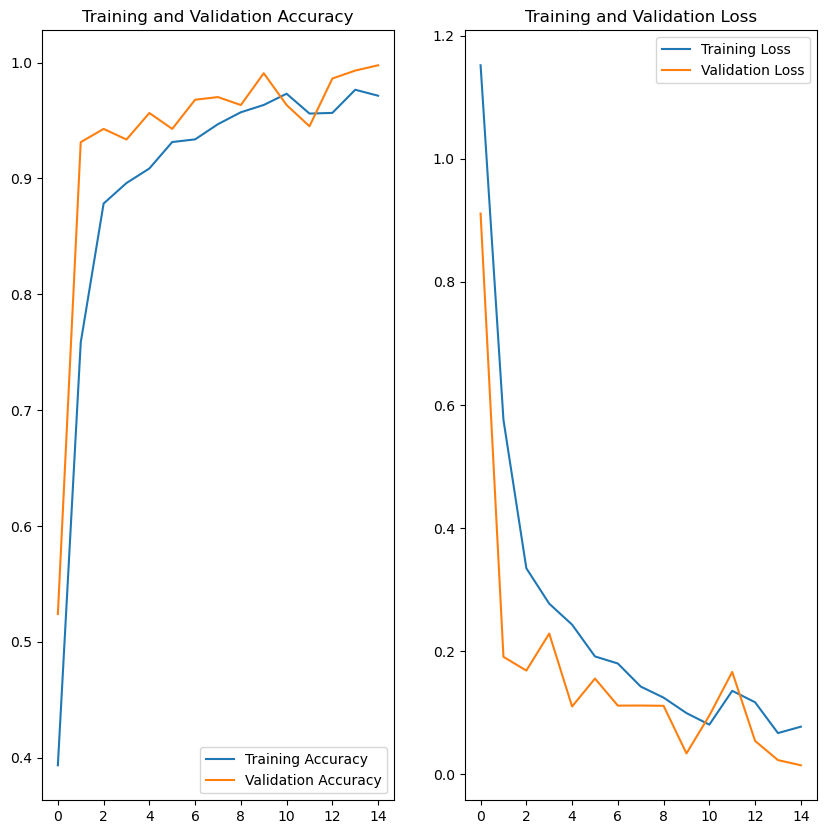

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10,10))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

<a id='predicting'></a>
# <b><div style='padding:15px;background-color:#850E35;color:white;border-radius:2px;font-size:110%;text-align: center'>Predicting on New Data</div></b>

In [19]:
random_image = random.sample(os.listdir(paper_dir), 1)
img = tf.keras.utils.load_img(f"{paper_dir}/{random_image[0]}", target_size=(180, 180))

img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)


1/1 [==============================] - 0s 193ms/step
This image most likely belongs to paper with a 100.00 percent confidence.


<a id='wrapup'></a>
# <b><div style='padding:15px;background-color:#850E35;color:white;border-radius:2px;font-size:110%;text-align: center'>Wrap-Up </div></b>

In this notebook, we've seen how to perform multiclass image classification. To do this, we've used Keras and TensorFlow. Finally, we discussed how to predict a new data.